In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from visual_eval import eval_binary_classification
from tqdm import tqdm
import os

DATA_DIR = os.path.join("..", "data")
MODEL_DIR = os.path.join("..", "models")

In [2]:
detailed_games_df = pd.read_csv(
    os.path.join(DATA_DIR, "AllSuperDetailedGames.csv"),
)

detailed_games_df.info()

/var/folders/v8/0hd98b512cn3ms2rz146k7jw0000gn/T/ipykernel_10013/685274063.py:1: DtypeWarning: Columns (503,504,505) have mixed types. Specify dtype option on import or set low_memory=False.
  detailed_games_df = pd.read_csv(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377608 entries, 0 to 377607
Columns: 511 entries, Unnamed: 0 to ChalkSeedDiff
dtypes: float64(455), int64(49), object(7)
memory usage: 1.4+ GB


In [ ]:
# join with 538 ratings
detailed_games_df = detailed_games_df.merge(
    right=pd.read_csv(os.path.join(DATA_DIR, "538"))
)

## Split Mens & Womens data

In [3]:
mens_games_df = detailed_games_df[detailed_games_df["League"] == "M"]
wmns_games_df = detailed_games_df[detailed_games_df["League"] == "W"]

## Define Features, Targets, and register data on device

In [4]:
# define the features and target for our models
feature_cols = [
    # "ChalkSeed",
    # "OppChalkSeed",
    "ChalkSeedDiff",
    "ScoreDiff mean reg",
    "FGMDiff mean reg",
    "FGM3Diff mean reg",
    "TODiff mean reg",
    "OppScore mean reg",
    "OppFGM mean reg",
    "OppFGM3 mean reg",
    "OppTO mean reg",
]

target_cols = ["Win"]

In [5]:
# split into training and testing datasets
mens_tourney_df = mens_games_df[mens_games_df["GameType"] == "tourney"]
MX_train, MX_test, My_train, My_test = train_test_split(
    mens_tourney_df[feature_cols],
    mens_tourney_df[target_cols],
    test_size=0.2,
    random_state=1,
)

# same for womens
wmns_tourney_df = wmns_games_df[wmns_games_df["GameType"] == "tourney"]
WX_train, WX_test, Wy_train, Wy_test = train_test_split(
    wmns_tourney_df[feature_cols],
    wmns_tourney_df[target_cols],
    test_size=0.2,
    random_state=1,
)

In [6]:
# convert data to tensor objects and register to device
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


def get_device() -> str:
    if torch.cuda.is_available():
        return "cuda"
    if torch.backends.mps.is_available():
        return "mps"
    return "cpu"


DEVICE = get_device()
print(DEVICE)

mps


In [7]:
MX_train_T = torch.tensor(
    MX_train.astype(float).values,
    dtype=torch.float32,
).to(DEVICE)

MX_test_T = torch.tensor(
    MX_test.astype(float).values,
    dtype=torch.float32,
).to(DEVICE)

My_train_T = torch.tensor(
    My_train.astype(float).values,
    dtype=torch.float32,
).to(DEVICE)

My_test_T = torch.tensor(
    My_test.astype(float).values,
    dtype=torch.float32,
).to(DEVICE)

# # same for womens data
WX_train_T = torch.tensor(
    WX_train.values,
    dtype=torch.float32,
).to(DEVICE)

WX_test_T = torch.tensor(
    WX_test.values,
    dtype=torch.float32,
).to(DEVICE)

Wy_train_T = torch.tensor(
    Wy_train.values,
    dtype=torch.float32,
).to(DEVICE)

Wy_test_T = torch.tensor(
    Wy_test.values,
    dtype=torch.float32,
).to(DEVICE)

# Generic Neural Network Framework

I am using the same neural network structure for both the mens and womens data

In [8]:
num_features = len(feature_cols)


class NiglNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation_func = nn.Sigmoid()
        self.layer1 = nn.Linear(num_features, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 8)
        self.layer5 = nn.Linear(8, 4)
        self.layer6 = nn.Linear(4, 1)

    def forward(self, x: torch.Tensor):
        x = self.layer1(x)
        x = self.activation_func(x)
        x = self.layer2(x)
        x = self.activation_func(x)
        x = self.layer3(x)
        x = self.activation_func(x)
        x = self.layer4(x)
        x = self.activation_func(x)
        x = self.layer5(x)
        x = self.activation_func(x)
        x = self.layer6(x)
        x = self.activation_func(x)
        return x

In [9]:
# mens training loop
torch.manual_seed(2)

mens_nigl10k = NiglNN().to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(lr=0.001, params=mens_nigl10k.parameters())

epochs = 10_000
with tqdm(range(1, epochs + 1), unit="epoch") as epochs:
    for epoch in epochs:
        optimizer.zero_grad()
        pred = mens_nigl10k(MX_train_T)
        loss = loss_fn(pred, My_train_T)
        loss.backward()
        optimizer.step()
        epochs.set_postfix(BCE=loss.item())

100%|██████████| 10000/10000 [01:46<00:00, 94.03epoch/s, BCE=0.641]


Binary Cross Entropy: 0.6580580472946167


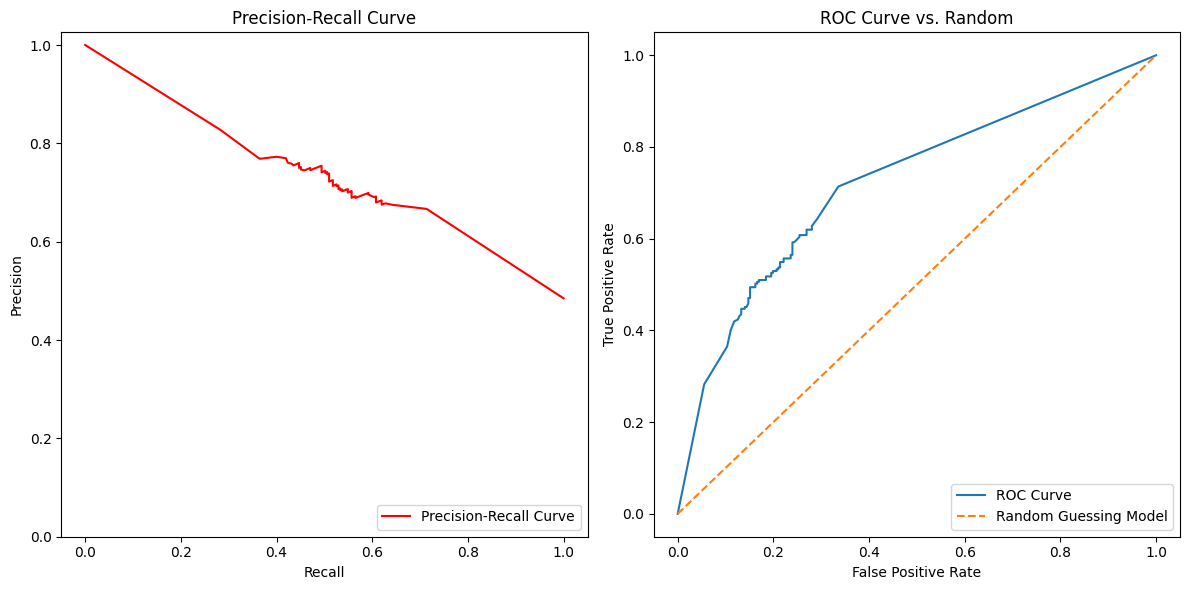

In [10]:
mens_nigl10k.eval()

with torch.no_grad():
    pred = mens_nigl10k(MX_test_T)
    loss = loss_fn(pred, My_test_T)
    print(f"Binary Cross Entropy: {loss.item()}")

    pred_arr = pred.cpu().numpy().flatten()
    true_labels = My_test_T.cpu().numpy().flatten()
    eval_binary_classification(pred=pred_arr, true=true_labels)


In [11]:
# save model because it is better than baseline
torch.save(mens_nigl10k, os.path.join(MODEL_DIR, "Mnn10k.pth"))

## Womens Neural Network

In [12]:
# use the same neural network architecture for the womens model
torch.manual_seed(2)

wmns_nigl10k = NiglNN().to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(lr=0.001, params=wmns_nigl10k.parameters())

epochs = 10_000
with tqdm(range(1, epochs + 1), unit="epoch") as epochs:
    for epoch in epochs:
        optimizer.zero_grad()
        pred = wmns_nigl10k(WX_train_T)
        loss = loss_fn(pred, Wy_train_T)
        loss.backward()
        optimizer.step()
        epochs.set_postfix(BCE=loss.item())

100%|██████████| 10000/10000 [01:45<00:00, 95.08epoch/s, BCE=0.602]


BCE: 0.6090894341468811


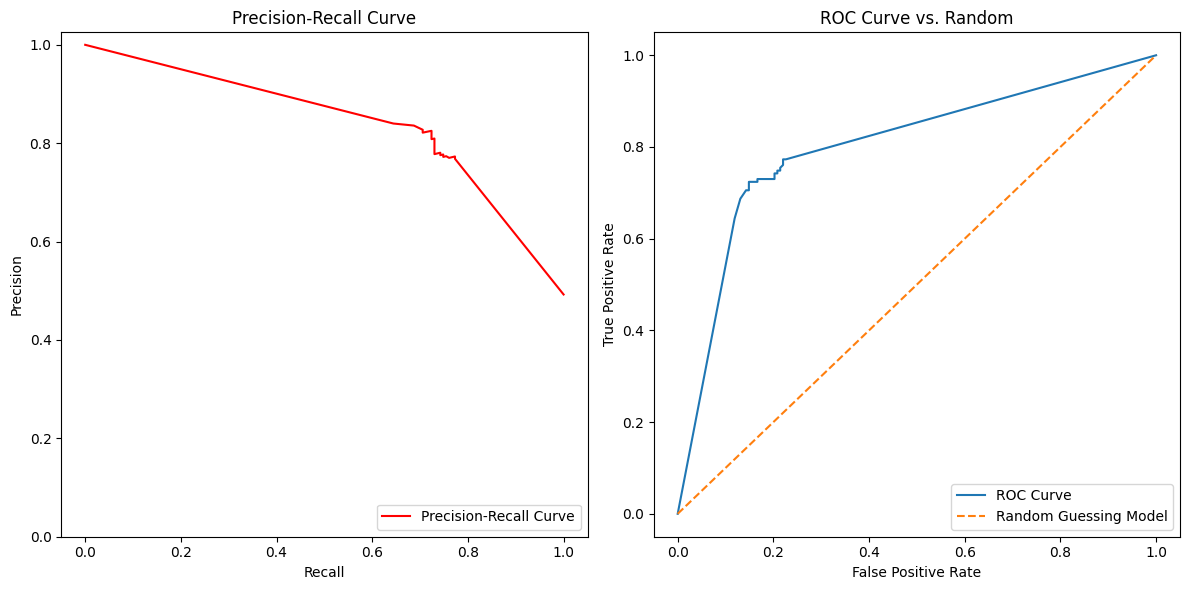

In [13]:
wmns_nigl10k.eval()

with torch.no_grad():
    pred = wmns_nigl10k(WX_test_T)
    loss = loss_fn(pred, Wy_test_T)
    print(f"BCE: {loss.item()}")

    pred_arr = pred.cpu().numpy().flatten()
    true_labels = Wy_test_T.cpu().numpy().flatten()
    eval_binary_classification(pred=pred_arr, true=true_labels)


In [14]:
# save it because it is better than womens baseline model
torch.save(wmns_nigl10k, os.path.join(MODEL_DIR, "Wnn10k.pth"))

## Final Predictions